In [5]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam

In [7]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('data/training_set/Parasitized')

In [8]:
train_paths_parasitized[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
train_paths_parasitized = ['data/training_set/Parasitized/' + i for i in train_paths_parasitized]

In [10]:
train_paths_uninfected += os.listdir('data/training_set/Uninfected')
train_paths_uninfected = ['data/training_set/Uninfected/' + i for i in train_paths_uninfected]

In [11]:
train_paths_uninfected[0]

'data/training_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [12]:

paths = train_paths_parasitized + train_paths_uninfected
# paths.remove("cell_images/Parasitized/Thumbs.db")
# paths.remove("cell_images/Uninfected/Thumbs.db")

In [13]:

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22048


In [14]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0


    if self.transform:
      image_pil = Image.fromarray(image)
      image = self.transform(image_pil)
      image=image.detach().numpy()
      image=np.transpose(image, (1, 2, 0))
    return image, label


In [15]:
IM_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomRotation(degrees=(0, 90)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Assuming RGB normalization
])


In [16]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

In [56]:
for i in range(22049):
    if(train_dataset.__getitem__(1)[0].any()==None):
        print(i)
    

In [53]:
train_dataset.__getitem__(1)[0].shape

(224, 224, 3)

In [ ]:
for i,data in enumerate(train_dataset):
    if data is None:
        print(f"{i} Found None in the dataset!")
        break

In [17]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [67]:
for inputs, labels in train_loader:
    # inputs will be a tensor of shape [32, channels, height, width]
    # labels will be a tensor of shape [32]
    if(inputs.any()==None):
        print(inputs)

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [60]:
image, label = next(iter(train_loader))
print(image[1][100:150,100:150,0])

tensor([[1.2557, 1.2557, 1.2557,  ..., 1.1700, 1.1700, 1.1872],
        [1.2557, 1.2385, 1.2557,  ..., 1.1872, 1.1872, 1.1700],
        [1.2385, 1.2214, 1.2557,  ..., 1.2043, 1.1872, 1.1872],
        ...,
        [1.1872, 1.2214, 1.2385,  ..., 1.2043, 1.2043, 1.1872],
        [1.2214, 1.2214, 1.2385,  ..., 1.2214, 1.2043, 1.1872],
        [1.2214, 1.2385, 1.2385,  ..., 1.2043, 1.2043, 1.1529]])


In [64]:
image.shape

torch.Size([32, 224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5942485].


tensor(1., dtype=torch.float64)


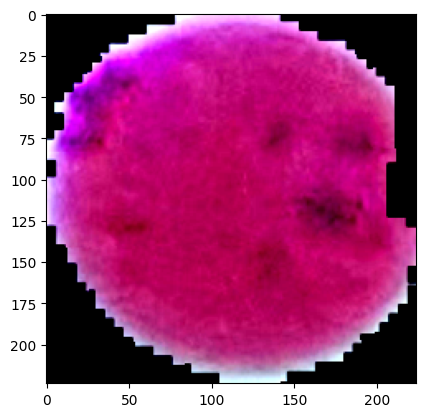

In [29]:
plt.imshow(image[0])
print(label[0])

In [31]:
image[0].shape

torch.Size([224, 224, 3])

In [35]:
image[0].view(-1, 16 * 56 * 56).shape

torch.Size([3, 50176])

In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 56 * 56, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.reshape(-1, 16 * 56 * 56)  # Reshape for the fully connected layer
        x = self.classifier(x)
        return x

In [38]:
model = LeNet()

op=model(torch.zeros((3,3,224,224)))


In [39]:
op.shape

torch.Size([3, 1])

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3, )

In [41]:
device

device(type='cuda', index=0)

In [42]:
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [43]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch, 100*epoch_accuracy/len(val_dataset)))

In [63]:
# for i, (image, label) in enumerate(train_loader):
#     print(image.shape)

In [57]:
def train(EPOCHS):

  model.to(device)

  for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
      print(i)
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      label = torch.unsqueeze(label, -1)
      label = label.float()
      label = label.to(device)

      optimizer.zero_grad()

      output = model(image)

      loss = loss_fn(output, label)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

      step_length = int(len(train_loader)/2)

      if(i%step_length) == 0:
              print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_loader), loss.item()))
    print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss/len(train_loader)))

    get_accuracy(epoch)


In [58]:
train(20)

0
Epoch Number: 1, step: [0|689] ----> Loss: 0.2898908257484436
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


AttributeError: 'NoneType' object has no attribute '__array_interface__'